# Time Series Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
import json

Using TensorFlow backend.


In [2]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [79]:
# Load the dataset
with open('feature_database.json') as json_database:
    database = json.load(json_database)

# Concat data from sector economy
X_eco_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'economy':
        new_data = pd.read_json(database[i]['data'])
        if X_eco_raw is None:
            X_eco_raw = new_data
        else:
            X_eco_raw = pd.concat([X_eco_raw, new_data], axis=1, join="inner")

dataset = X_eco_raw.values
dataset = dataset.astype('float64')
print(dataset.shape)

# Split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train= dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]

# Reshape dataset
look_back = 3
trainX = np.zeros((dataset.shape[1], len(train)-look_back-1, look_back))
trainY = np.zeros((dataset.shape[1], len(train)-look_back-1))
testX = np.zeros((dataset.shape[1], len(test)-look_back-1, look_back))
testY = np.zeros((dataset.shape[1], len(test)-look_back-1))
for i in range(dataset.shape[1]):
    trainX[i, :], trainY[i, :] = create_dataset(train[:, i], look_back)
    testX[i, :], testY[i, :] = create_dataset(test[:, i], look_back)
X_eco_raw.tail()

(183, 12)


,ECO_Consumer_Price_Index,ECO_Unemployment_Number,ECO_DAX,ECO_MDAX,ECO_Wholesale_Turnover,ECO_Retail_Sales,ECO_Accommodation,ECO_Hotels_Inns_Guesthouses,ECO_Gastronomy,FuelSale_rohbenzin_tons_insg,FuelSale_rohbenzin_tons_chemWeiterVera,FuelSale_rohbenzin_tons_sonstige
2019-11-01,105.3,2179999,13200.829520,27140.310547,112.8,119.8,100.1,103.3,102.4,1004661,978784,25877
2019-12-01,105.8,2227159,13193.275608,27769.542969,105.3,126.4,96.1,99.0,111.1,1157221,1134469,22752
2020-01-01,105.2,2425523,13370.523526,28461.220703,105.2,105.3,80.8,81.3,91.0,1030746,1002514,28232
2020-02-01,105.6,2395604,13330.550537,28411.579590,104.0,104.3,84.5,86.3,91.4,990010,963089,26921
2020-03-01,105.7,2335367,10034.256747,21568.920543,119.4,109.6,48.2,48.0,58.0,989951,959371,30580


## Multilayer Perceptron Regression

In [71]:
# Regressions forecast model with windowing method
def train_model(trainX, trainY, testX,  testY):
    model = Sequential()
    model.add(Dense(12, input_dim=look_back, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [72]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
models = [None for _ in range(dataset.shape[1])]

for i in range(dataset.shape[1]):
    # Train model and generate predictions
    models[i], trainPredict, testPredict = train_model(trainX[i], trainY[i], 
                                                       testX[i],  testY[i])

    # Shift train predictions for plotting
    trainPredictPlot[look_back:len(trainPredict)+look_back, i] = trainPredict[:, 0]
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, i] = testPredict[:, 0]

Streaming output truncated to the last 5000 lines.
 - 0s - loss: 67.5161
Epoch 309/400
 - 0s - loss: 72.7094
Epoch 310/400
 - 0s - loss: 71.8882
Epoch 311/400
 - 0s - loss: 72.2469
Epoch 312/400
 - 0s - loss: 70.8828
Epoch 313/400
 - 0s - loss: 70.6418
Epoch 314/400
 - 0s - loss: 71.8818
Epoch 315/400
 - 0s - loss: 72.0816
Epoch 316/400
 - 0s - loss: 75.7660
Epoch 317/400
 - 0s - loss: 71.7473
Epoch 318/400
 - 0s - loss: 69.8309
Epoch 319/400
 - 0s - loss: 73.6964
Epoch 320/400
 - 0s - loss: 73.4960
Epoch 321/400
 - 0s - loss: 73.8876
Epoch 322/400
 - 0s - loss: 70.8051
Epoch 323/400
 - 0s - loss: 71.2216
Epoch 324/400
 - 0s - loss: 71.6253
Epoch 325/400
 - 0s - loss: 69.6695
Epoch 326/400
 - 0s - loss: 76.2162
Epoch 327/400
 - 0s - loss: 72.8870
Epoch 328/400
 - 0s - loss: 70.2011
Epoch 329/400
 - 0s - loss: 73.0952
Epoch 330/400
 - 0s - loss: 70.0603
Epoch 331/400
 - 0s - loss: 69.9253
Epoch 332/400
 - 0s - loss: 72.6749
Epoch 333/400
 - 0s - loss: 74.9205
Epoch 334/400
 - 0s - loss:

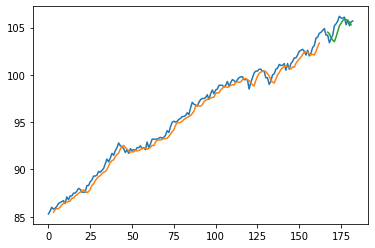

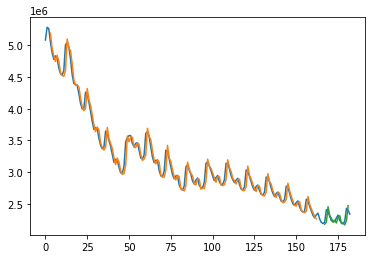

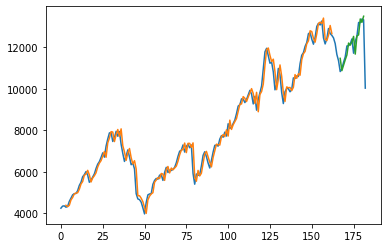

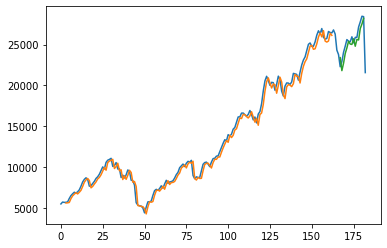

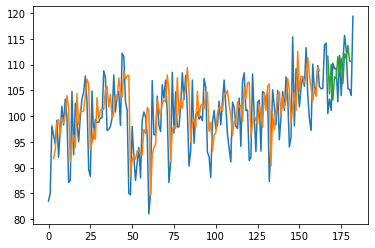

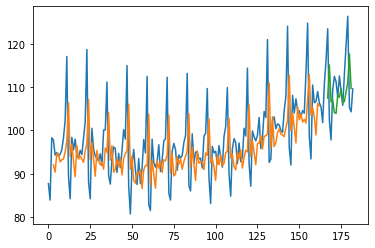

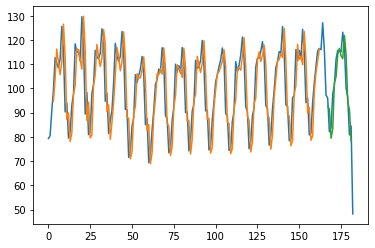

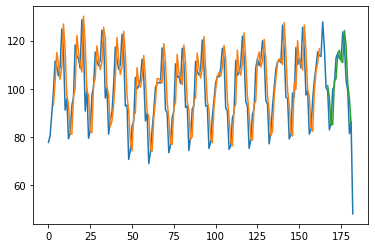

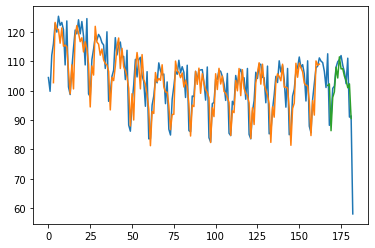

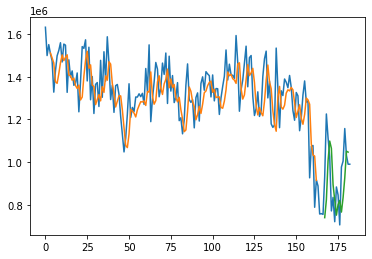

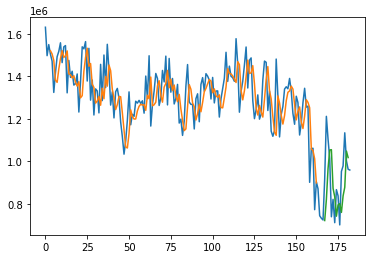

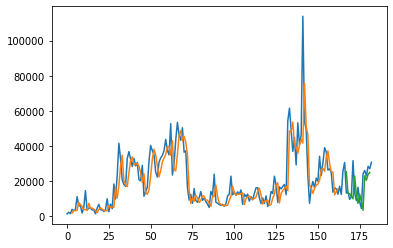

In [74]:
# Plot baseline and predictions
for i in range(dataset.shape[1]):
    plt.plot(dataset[:, i])
    plt.plot(trainPredictPlot[:, i])
    plt.plot(testPredictPlot[:, i])
    plt.show()

In [9]:
import pickle

# Save variables
with open('objs.pkl', 'wb') as f:
    pickle.dump([models, trainPredictPlot, testPredictPlot], f)

# Getting back the objects:
with open('objs.pkl', 'rb') as f:
    models, trainPlot, testPlot = pickle.load(f)

In [81]:
# Forecast predictions
horizon = 10    # months
forecastPlot = np.zeros((len(dataset) + horizon, dataset.shape[1]))
forecastPlot[:, :] = np.nan
X = np.zeros((1, look_back))

for i in range(dataset.shape[1]):
    predict = None
    for t in range(horizon):
        if predict is None:
            # Get last window of time series
            X[0] = dataset[len(dataset)-3:, i]
            print(X)
            predict = models[i].predict(X)
        else:
            # Add newest prediction
            X[0, 0:2] = X[0, 1:]
            X[0, -1] = predict
            predict = models[i].predict(X)
        forecastPlot[len(dataset)+t, i] = predict[0]

[[105.2 105.6 105.7]]
[[2425523. 2395604. 2335367.]]
[[13370.52352632 13330.55053705 10034.25674723]]
[[28461.22070314 28411.57958985 21568.92054345]]
[[105.2 104.  119.4]]
[[105.3 104.3 109.6]]
[[80.8 84.5 48.2]]
[[81.3 86.3 48. ]]
[[91.  91.4 58. ]]
[[1030746.  990010.  989951.]]
[[1002514.  963089.  959371.]]
[[28232. 26921. 30580.]]


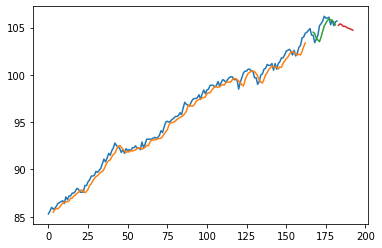

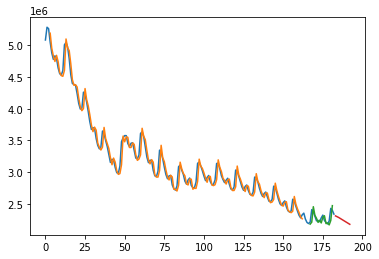

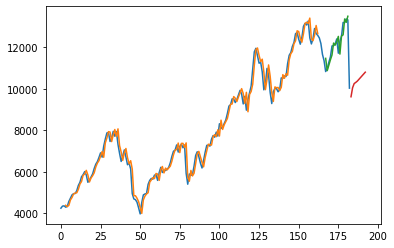

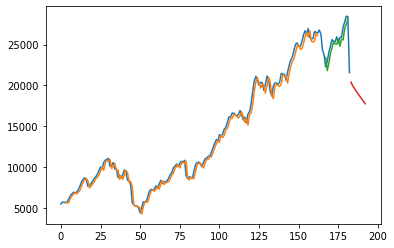

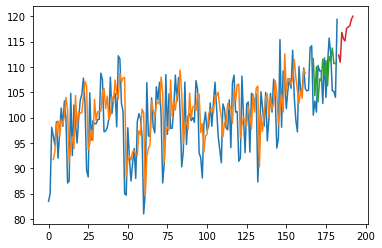

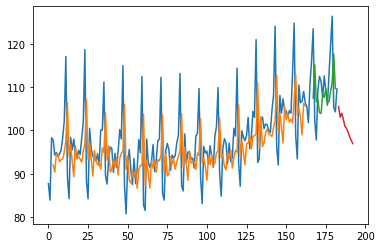

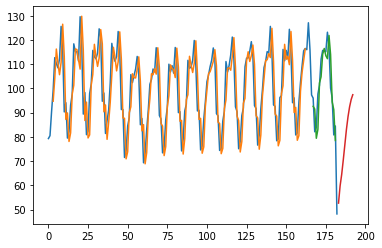

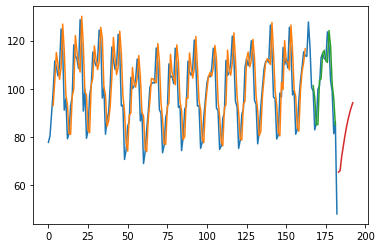

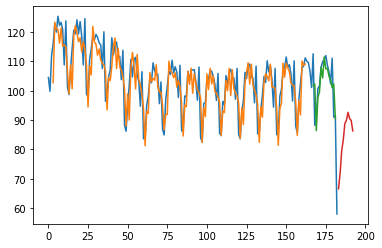

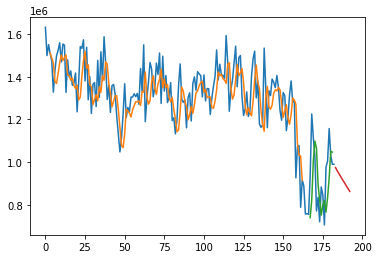

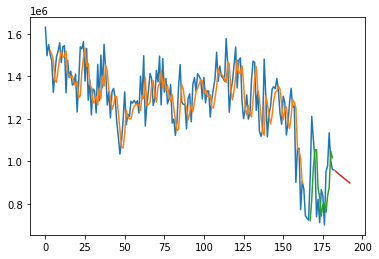

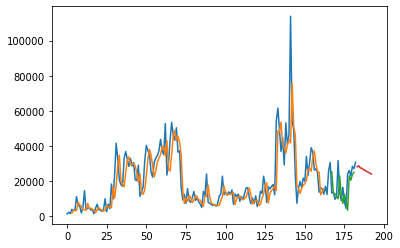

In [82]:
# Plot baseline and predictions
for i in range(dataset.shape[1]):
    plt.plot(dataset[:, i])
    plt.plot(trainPredictPlot[:, i])
    plt.plot(testPredictPlot[:, i])
    plt.plot(forecastPlot[:, i])
    plt.show()